In [1]:
# Install dependencies (for Colab)
!pip install -q transformers datasets torch accelerate scikit-learn matplotlib

In [2]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# Setup paths
import os
from pathlib import Path

PROJECT_ROOT = Path('/content/drive/MyDrive/574-assignment')
DATA_PATH = PROJECT_ROOT / 'data' / 'generated'
MODEL_PATH = PROJECT_ROOT / 'models' / 'joint_classifier'
RESULTS_PATH = PROJECT_ROOT / 'results'

MODEL_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Model path: {MODEL_PATH}")

# Verify data files
print("\nChecking data files:")
for f in ['train.json', 'val.json', 'test.json', 'label_mappings.json']:
    if (DATA_PATH / f).exists():
        print(f"  ✓ Found {f}")
    else:
        print(f"  ✗ Missing {f}")

Mounted at /content/drive
Project root: /content/drive/MyDrive/574-assignment
Data path: /content/drive/MyDrive/574-assignment/data/generated
Model path: /content/drive/MyDrive/574-assignment/models/joint_classifier

Checking data files:
  ✓ Found train.json
  ✓ Found val.json
  ✓ Found test.json
  ✓ Found label_mappings.json


In [3]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DebertaV2TokenizerFast,
    DebertaV2Model,
    DebertaV2PreTrainedModel,
    get_linear_schedule_with_warmup,
    AutoConfig
)
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm

# Check device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CUDA: NVIDIA L4


## 1. Configuration

In [29]:
# Training configuration
CONFIG = {
    # Model
    'model_name': 'microsoft/deberta-v3-base',
    'max_length': 128,
    'classifier_dropout': 0.1,

    # Training
    'batch_size': 32,
    'encoder_lr': 1e-5,       # Lower LR for pretrained encoder
    'head_lr': 1e-4,          # Higher LR for new classification heads
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,

    # Staged training
    'stage1_epochs': 3,       # Tool head only
    'stage2_epochs': 11,       # All heads (joint)
    'patience': 3,

    # Focal Loss
    'focal_gamma': 2.0,       # Focusing parameter
    'label_smoothing': 0.1,   # For calibration

    # Loss weights
    'tool_loss_weight': 1.0,
    'intent_loss_weight': 1.0,
}

# Load label mappings
with open(DATA_PATH / 'label_mappings.json') as f:
    LABEL_MAPPINGS = json.load(f)

TOOL_TO_IDX = LABEL_MAPPINGS['tool_to_idx']
IDX_TO_TOOL = {int(k): v for k, v in LABEL_MAPPINGS['idx_to_tool'].items()}
TOOLS = list(TOOL_TO_IDX.keys())

INTENT_TO_IDX_PER_TOOL = LABEL_MAPPINGS['intent_to_idx_per_tool']
IDX_TO_INTENT_PER_TOOL = LABEL_MAPPINGS['idx_to_intent_per_tool']
NUM_INTENTS_PER_TOOL = LABEL_MAPPINGS['num_intents_per_tool']

# Preserved placeholders (for reference)
PRESERVED_PLACEHOLDERS = LABEL_MAPPINGS.get('preserved_placeholders', [])

print(f"Tools: {TOOLS}")
print(f"\nIntents per tool:")
for tool, num in NUM_INTENTS_PER_TOOL.items():
    print(f"  {tool}: {num}")
print(f"\nTotal intents: {sum(NUM_INTENTS_PER_TOOL.values())}")
print(f"\nPreserved placeholders: {PRESERVED_PLACEHOLDERS}")

Tools: ['character_data', 'session_notes', 'rulebook']

Intents per tool:
  character_data: 10
  session_notes: 20
  rulebook: 30

Total intents: 60

Preserved placeholders: ['{NPC}', '{PARTY_MEMBER}', '{CHARACTER}']


## 2. Load Dataset

In [5]:
def load_dataset(split='train'):
    """Load dataset from JSON file."""
    path = DATA_PATH / f'{split}.json'
    with open(path) as f:
        data = json.load(f)
    print(f"Loaded {len(data)} {split} samples")
    return data

train_data = load_dataset('train')
val_data = load_dataset('val')
test_data = load_dataset('test')

# Show sample
print("\nSample structure:")
print(json.dumps(train_data[0], indent=2))

Loaded 12727 train samples
Loaded 1591 val samples
Loaded 1591 test samples

Sample structure:
{
  "text": "What's the trade-off between Mace and Spear?",
  "tool": "rulebook",
  "intent": "compare_entities"
}


## 3. Dataset Class

In [6]:
class ClassificationDataset(Dataset):
    """
    Dataset for tool + intent classification.

    Each sample has:
    - text: The query text (may contain {CHARACTER}, {PARTY_MEMBER}, {NPC})
    - tool: Single tool name
    - intent: Intent for that tool
    """

    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample['text']
        tool = sample['tool']
        intent = sample['intent']

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tool label (single class)
        tool_label = TOOL_TO_IDX[tool]

        # Intent labels per tool (-100 for non-selected tools)
        intent_label_character = -100
        intent_label_session = -100
        intent_label_rulebook = -100

        if tool == 'character_data':
            intent_label_character = INTENT_TO_IDX_PER_TOOL['character_data'][intent]
        elif tool == 'session_notes':
            intent_label_session = INTENT_TO_IDX_PER_TOOL['session_notes'][intent]
        elif tool == 'rulebook':
            intent_label_rulebook = INTENT_TO_IDX_PER_TOOL['rulebook'][intent]

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'tool_label': torch.tensor(tool_label, dtype=torch.long),
            'intent_label_character': torch.tensor(intent_label_character, dtype=torch.long),
            'intent_label_session': torch.tensor(intent_label_session, dtype=torch.long),
            'intent_label_rulebook': torch.tensor(intent_label_rulebook, dtype=torch.long),
        }


def collate_fn(batch):
    """Custom collate function."""
    return {
        'input_ids': torch.stack([x['input_ids'] for x in batch]),
        'attention_mask': torch.stack([x['attention_mask'] for x in batch]),
        'tool_label': torch.stack([x['tool_label'] for x in batch]),
        'intent_label_character': torch.stack([x['intent_label_character'] for x in batch]),
        'intent_label_session': torch.stack([x['intent_label_session'] for x in batch]),
        'intent_label_rulebook': torch.stack([x['intent_label_rulebook'] for x in batch]),
    }

## 4. Focal Loss Implementation

In [7]:
class FocalLoss(nn.Module):
    """
    Focal Loss with Label Smoothing.

    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)

    Args:
        gamma: Focusing parameter (default 2.0)
        label_smoothing: Label smoothing factor (default 0.1)
        ignore_index: Index to ignore in loss computation (default -100)
        alpha: Weighting factor (default 1.0)
    """

    def __init__(self, gamma=2.0, label_smoothing=0.1, ignore_index=-100, reduction='mean', alpha=1.0):
        super().__init__()
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, logits, targets):
        """
        Args:
            logits: (batch_size, num_classes)
            targets: (batch_size,)
        """
        num_classes = logits.size(-1)

        # Label smoothing: convert hard labels to soft labels
        if self.label_smoothing > 0:
            with torch.no_grad():
                smooth_targets = torch.zeros_like(logits)
                smooth_targets.fill_(self.label_smoothing / (num_classes - 1))
                smooth_targets.scatter_(1, targets.unsqueeze(1), 1 - self.label_smoothing)

        # Compute softmax probabilities
        probs = F.softmax(logits, dim=-1)

        # Get probability of correct class
        p_t = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Focal weight: (1 - p_t)^gamma
        focal_weight = (1 - p_t) ** self.gamma

        # Cross-entropy loss with optional label smoothing
        if self.label_smoothing > 0:
            log_probs = F.log_softmax(logits, dim=-1)
            ce_loss = -(smooth_targets * log_probs).sum(dim=-1)
        else:
            ce_loss = F.cross_entropy(logits, targets, reduction='none')

        # Apply focal weight and class weight
        loss = self.alpha * focal_weight * ce_loss

        return loss.mean()


# Test focal loss
# focal_loss = FocalLoss(gamma=2.0, label_smoothing=0.1)
# test_logits = torch.randn(4, 3)
# test_targets = torch.tensor([0, 1, 2, 0])
# print(f"Focal loss: {focal_loss(test_logits, test_targets):.4f}")

## 5. Model Architecture

In [8]:
class JointClassifier(DebertaV2PreTrainedModel):
    """
    Joint Tool + Intent Classifier using DeBERTa-v3.

    Architecture:
    - Shared DeBERTa encoder
    - Tool classification head (3 classes)
    - Per-tool intent heads (10 + 20 + 30 classes)
    - Temperature parameter for calibration

    No NER - entity extraction handled by gazetteer at inference.
    """

    def __init__(self, config, num_tools=3,
                 num_character_intents=10,
                 num_session_intents=20,
                 num_rulebook_intents=30):
        super().__init__(config)

        self.num_tools = num_tools
        self.num_character_intents = num_character_intents
        self.num_session_intents = num_session_intents
        self.num_rulebook_intents = num_rulebook_intents

        # Shared encoder
        self.deberta = DebertaV2Model(config)

        # Dropout
        classifier_dropout = getattr(config, 'classifier_dropout', 0.1)
        self.dropout = nn.Dropout(classifier_dropout)

        # Tool classification head
        self.tool_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(config.hidden_size, num_tools)
        )

        # Per-tool intent heads
        self.character_intent_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(config.hidden_size, num_character_intents)
        )
        self.session_intent_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(config.hidden_size, num_session_intents)
        )
        self.rulebook_intent_head = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Dropout(classifier_dropout),
            nn.Linear(config.hidden_size, num_rulebook_intents)
        )
        self.temperature = nn.Parameter(torch.ones(1))

        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        tool_label=None,
        intent_label_character=None,
        intent_label_session=None,
        intent_label_rulebook=None,
        stage='all',  # 'stage1' (tool only), 'all' (tool + intent)
        use_temperature=False,  # Apply temperature scaling
    ):
        """
        Forward pass.

        Returns dict with:
        - loss: Combined loss
        - tool_logits: (batch, num_tools)
        - character_intent_logits: (batch, num_character_intents)
        - session_intent_logits: (batch, num_session_intents)
        - rulebook_intent_logits: (batch, num_rulebook_intents)
        """
        # Encode with DeBERTa
        outputs = self.deberta(input_ids, attention_mask=attention_mask)

        # Get [CLS] token output
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)

        # Tool logits
        tool_logits = self.tool_head(cls_output)

        # Intent logits for all tools
        intent_logits = {
            'character': self.character_intent_head(cls_output),
            'session_notes': self.session_intent_head(cls_output),
            'rulebook': self.rulebook_intent_head(cls_output),
        }

        # Apply temperature scaling if requested
        if use_temperature and self.temperature.item() != 1.0:
            tool_logits = tool_logits / self.temperature
            intent_logits = {k: v / self.temperature for k, v in intent_logits.items()}

        return tool_logits, intent_logits

    def freeze_intent_heads(self):
        """Freeze intent heads for Stage 1 training."""
        for head in [self.character_intent_head, self.session_intent_head, self.rulebook_intent_head]:
            if head is not None:
                for param in head.parameters():
                    param.requires_grad = False

    def unfreeze_intent_heads(self):
        """Unfreeze intent heads for Stage 2 training."""
        for head in [self.character_intent_head, self.session_intent_head, self.rulebook_intent_head]:
            if head is not None:
                for param in head.parameters():
                    param.requires_grad = True

## 6. Initialize Model & Data

In [9]:
# Load tokenizer
print(f"Loading model: {CONFIG['model_name']}")
tokenizer = DebertaV2TokenizerFast.from_pretrained(CONFIG['model_name'])

# Load config
config = AutoConfig.from_pretrained(CONFIG['model_name'])
config.classifier_dropout = CONFIG['classifier_dropout']

# Initialize model
model = JointClassifier.from_pretrained(
    CONFIG['model_name'],
    config=config,
    num_tools=len(TOOLS),
    num_character_intents=NUM_INTENTS_PER_TOOL['character_data'],
    num_session_intents=NUM_INTENTS_PER_TOOL['session_notes'],
    num_rulebook_intents=NUM_INTENTS_PER_TOOL['rulebook'],
    ignore_mismatched_sizes=True
)
model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading model: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of JointClassifier were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['character_intent_head.0.bias', 'character_intent_head.0.weight', 'character_intent_head.3.bias', 'character_intent_head.3.weight', 'rulebook_intent_head.0.bias', 'rulebook_intent_head.0.weight', 'rulebook_intent_head.3.bias', 'rulebook_intent_head.3.weight', 'session_intent_head.0.bias', 'session_intent_head.0.weight', 'session_intent_head.3.bias', 'session_intent_head.3.weight', 'temperature', 'tool_head.0.bias', 'tool_head.0.weight', 'tool_head.3.bias', 'tool_head.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


Total parameters: 186,242,368
Trainable parameters: 186,242,368


In [10]:
# Create datasets
train_dataset = ClassificationDataset(train_data, tokenizer, CONFIG['max_length'])
val_dataset = ClassificationDataset(val_data, tokenizer, CONFIG['max_length'])
test_dataset = ClassificationDataset(test_data, tokenizer, CONFIG['max_length'])

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 398
Val batches: 50
Test batches: 50


## 7. Optimizer with Differential Learning Rates

In [11]:
def get_optimizer(model, num_training_steps, encoder_lr=1e-5, head_lr=1e-4):
    """
    Create optimizer with differential learning rates.

    - Encoder (DeBERTa): Lower LR (1e-5)
    - Classification heads: Higher LR (1e-4)
    """
    # Parameter groups
    encoder_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'deberta' in name:
            encoder_params.append(param)
        else:
            head_params.append(param)

    optimizer_grouped_parameters = [
        {'params': encoder_params, 'lr': encoder_lr, 'weight_decay': 0.01},
        {'params': head_params, 'lr': head_lr, 'weight_decay': 0.01},
    ]

    optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

    # Linear warmup + decay scheduler
    warmup_steps = int(num_training_steps * CONFIG['warmup_ratio'])
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps
    )

    return optimizer, scheduler

print(f"✓ get_optimizer() with differential LRs: encoder={CONFIG['encoder_lr']}, heads={CONFIG['head_lr']}")


✓ get_optimizer() with differential LRs: encoder=1e-05, heads=0.0001


## 8. Evaluation Functions

In [18]:
def evaluate(model, dataloader, focal_loss, device, label_mappings, stage='all'):
    """
    Evaluate model on validation/test set.

    Returns:
        dict with metrics:
        - loss
        - tool_accuracy, tool_f1
        - character_data_intent_acc, session_notes_intent_acc, rulebook_intent_acc
        - avg_intent_acc
    """
    model.eval()

    all_tool_preds, all_tool_labels = [], []
    # Use official tool names as keys
    intent_preds = {'character_data': [], 'session_notes': [], 'rulebook': []}
    intent_labels = {'character_data': [], 'session_notes': [], 'rulebook': []}

    total_loss = 0.0
    idx_to_tool = {v: k for k, v in label_mappings['tool_to_idx'].items()}

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tool_label = batch['tool_label'].to(device)

            tool_logits, intent_logits_dict = model(input_ids, attention_mask)

            # Align logits keys: map 'character' -> 'character_data'
            if 'character' in intent_logits_dict:
                intent_logits_dict['character_data'] = intent_logits_dict['character']

            # Construct intent labels dict from flat batch keys
            intent_labels_batch = {
                'character_data': batch['intent_label_character'].to(device),
                'session_notes': batch['intent_label_session'].to(device),
                'rulebook': batch['intent_label_rulebook'].to(device)
            }

            # Tool loss
            loss = focal_loss(tool_logits, tool_label)

            # Intent loss (if stage != 'stage1')
            if stage != 'stage1':
                for tool_name in ['character_data', 'session_notes', 'rulebook']:
                    mask = intent_labels_batch[tool_name] != -100
                    if mask.any():
                        intent_logits = intent_logits_dict[tool_name][mask]
                        intent_targets = intent_labels_batch[tool_name][mask]
                        loss += focal_loss(intent_logits, intent_targets)

            total_loss += loss.item()

            # Tool predictions
            tool_preds = torch.argmax(tool_logits, dim=-1)
            all_tool_preds.extend(tool_preds.cpu().tolist())
            all_tool_labels.extend(tool_label.cpu().tolist())

            # Intent predictions (by predicted tool)
            if stage != 'stage1':
                for i, (pred_tool_idx, true_tool_idx) in enumerate(zip(tool_preds, tool_label)):
                    true_tool = idx_to_tool[true_tool_idx.item()]
                    # Only track if we have a valid target label
                    intent_target = intent_labels_batch[true_tool][i].item()
                    if intent_target != -100:
                        intent_logit = intent_logits_dict[true_tool][i]
                        intent_pred = torch.argmax(intent_logit).item()
                        intent_preds[true_tool].append(intent_pred)
                        intent_labels[true_tool].append(intent_target)

    # Compute metrics
    metrics = {
        'loss': total_loss / len(dataloader),
        'tool_accuracy': accuracy_score(all_tool_labels, all_tool_preds),
        'tool_f1': f1_score(all_tool_labels, all_tool_preds, average='macro'),
    }

    # Per-tool intent accuracy
    if stage != 'stage1':
        intent_accs = []
        for tool_name in ['character_data', 'session_notes', 'rulebook']:
            if intent_labels[tool_name]:
                acc = accuracy_score(intent_labels[tool_name], intent_preds[tool_name])
                metrics[f'{tool_name}_intent_acc'] = acc
                intent_accs.append(acc)
            else:
                metrics[f'{tool_name}_intent_acc'] = 0.0
        metrics['avg_intent_acc'] = sum(intent_accs) / len(intent_accs) if intent_accs else 0.0

    return metrics

print("✓ evaluate() function defined")

✓ evaluate() function defined


## 9. Training Loop

In [21]:
def train_epoch(model, dataloader, optimizer, scheduler, focal_loss, device, label_mappings, stage='all'):
    """
    Train for one epoch.
    """
    model.train()

    total_loss = 0.0
    all_tool_preds, all_tool_labels = [], []

    for batch in tqdm(dataloader, desc=f'Training ({stage})'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        tool_label = batch['tool_label'].to(device)

        optimizer.zero_grad()

        tool_logits, intent_logits_dict = model(input_ids, attention_mask)

        # Align logits keys
        if 'character' in intent_logits_dict:
            intent_logits_dict['character_data'] = intent_logits_dict['character']

        # Construct intent labels dict
        intent_labels_batch = {
            'character_data': batch['intent_label_character'].to(device),
            'session_notes': batch['intent_label_session'].to(device),
            'rulebook': batch['intent_label_rulebook'].to(device)
        }

        # Tool loss (always computed)
        loss = focal_loss(tool_logits, tool_label)

        # Intent loss (only in stage 'all')
        if stage == 'all':
            for tool_name in ['character_data', 'session_notes', 'rulebook']:
                mask = intent_labels_batch[tool_name] != -100
                if mask.any():
                    intent_logits = intent_logits_dict[tool_name][mask]
                    intent_targets = intent_labels_batch[tool_name][mask]
                    loss += focal_loss(intent_logits, intent_targets)

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Track predictions
        tool_preds = torch.argmax(tool_logits, dim=-1)
        all_tool_preds.extend(tool_preds.cpu().tolist())
        all_tool_labels.extend(tool_label.cpu().tolist())

    return {
        'loss': total_loss / len(dataloader),
        'tool_accuracy': accuracy_score(all_tool_labels, all_tool_preds),
    }

print("✓ train_epoch() function defined")

✓ train_epoch() function defined


## 10. Stage 1: Tool Classification

In [16]:
# Stage 1: Train tool head only (intent heads frozen)
print("=" * 70)
print("STAGE 1: Training Tool Head (intent heads frozen)")
print("=" * 70)

# Freeze intent heads
model.freeze_intent_heads()

# Instantiate Focal Loss
focal_loss = FocalLoss(gamma=CONFIG['focal_gamma'], label_smoothing=CONFIG['label_smoothing'])

# Create optimizer (excluding intent heads - they're frozen anyway, but explicit)
optimizer_s1, scheduler_s1 = get_optimizer(
    model,
    num_training_steps=len(train_loader) * CONFIG['stage1_epochs'],
    encoder_lr=CONFIG['encoder_lr'],
    head_lr=CONFIG['head_lr']
)

# Initialize tracking
training_history = []
best_tool_acc = 0.0

for epoch in range(1, CONFIG['stage1_epochs'] + 1):
    print(f"\n--- Stage 1 | Epoch {epoch}/{CONFIG['stage1_epochs']} ---")

    train_metrics = train_epoch(
        model, train_loader, optimizer_s1, scheduler_s1,
        focal_loss, device, LABEL_MAPPINGS, stage='stage1'
    )

    val_metrics = evaluate(model, val_loader, focal_loss, device, LABEL_MAPPINGS, stage='stage1')

    print(f"Train Loss: {train_metrics['loss']:.4f} | Tool Acc: {train_metrics['tool_accuracy']:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Tool Acc: {val_metrics['tool_accuracy']:.4f} | F1: {val_metrics['tool_f1']:.4f}")

    training_history.append({
        'epoch': epoch,
        'stage': 'stage1',
        'train_loss': train_metrics['loss'],
        'train_tool_acc': train_metrics['tool_accuracy'],
        'val_loss': val_metrics['loss'],
        'val_tool_acc': val_metrics['tool_accuracy'],
        'val_tool_f1': val_metrics['tool_f1'],
        # Placeholders for Stage 2 metrics
        'val_character_intent_acc': 0.0,
        'val_session_intent_acc': 0.0,
        'val_rulebook_intent_acc': 0.0,
        'val_avg_intent_acc': 0.0,
        'combined_score': val_metrics['tool_accuracy'],
    })

    if val_metrics['tool_accuracy'] > best_tool_acc:
        best_tool_acc = val_metrics['tool_accuracy']
        torch.save(model.state_dict(), RESULTS_PATH / 'best_model_stage1.pt')
        print(f"  → New best tool accuracy: {best_tool_acc:.4f}")

print(f"\n✓ Stage 1 complete. Best tool accuracy: {best_tool_acc:.4f}")

STAGE 1: Training Tool Head (intent heads frozen)

--- Stage 1 | Epoch 1/3 ---


Training (stage1):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.1522 | Tool Acc: 0.8639
Val Loss: 0.0468 | Tool Acc: 0.9717 | F1: 0.9630
  → New best tool accuracy: 0.9717

--- Stage 1 | Epoch 2/3 ---


Training (stage1):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0343 | Tool Acc: 0.9772
Val Loss: 0.0189 | Tool Acc: 0.9868 | F1: 0.9824
  → New best tool accuracy: 0.9868

--- Stage 1 | Epoch 3/3 ---


Training (stage1):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0172 | Tool Acc: 0.9868
Val Loss: 0.0156 | Tool Acc: 0.9874 | F1: 0.9831
  → New best tool accuracy: 0.9874

✓ Stage 1 complete. Best tool accuracy: 0.9874


## 11. Stage 2: Joint Training

In [30]:
# Stage 2: Joint training of all heads
print("\n" + "=" * 70)
print("STAGE 2: Joint Training (all heads)")
print("=" * 70)

# Unfreeze intent heads
model.unfreeze_intent_heads()

# Instantiate Focal Loss (ensure it exists)
focal_loss = FocalLoss(gamma=CONFIG['focal_gamma'], label_smoothing=CONFIG['label_smoothing'])

# Create optimizer for all parameters
optimizer_s2, scheduler_s2 = get_optimizer(
    model,
    num_training_steps=len(train_loader) * CONFIG['stage2_epochs'],
    encoder_lr=CONFIG['encoder_lr'],
    head_lr=CONFIG['head_lr']
)

# Early stopping setup
best_combined_score = 0.0
patience_counter = 0
epoch_offset = CONFIG['stage1_epochs']

for epoch in range(1, CONFIG['stage2_epochs'] + 1):
    global_epoch = epoch_offset + epoch
    print(f"\n--- Stage 2 | Epoch {epoch}/{CONFIG['stage2_epochs']} (Global: {global_epoch}) ---")

    train_metrics = train_epoch(
        model, train_loader, optimizer_s2, scheduler_s2,
        focal_loss, device, LABEL_MAPPINGS, stage='all'
    )

    val_metrics = evaluate(model, val_loader, focal_loss, device, LABEL_MAPPINGS, stage='all')

    # Combined score: 0.4 * tool_acc + 0.6 * avg_intent_acc
    combined_score = 0.4 * val_metrics['tool_accuracy'] + 0.6 * val_metrics['avg_intent_acc']

    print(f"Train Loss: {train_metrics['loss']:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Tool Acc: {val_metrics['tool_accuracy']:.4f}")
    print(f"Intent Acc - Char: {val_metrics['character_data_intent_acc']:.4f} | "
          f"Session: {val_metrics['session_notes_intent_acc']:.4f} | "
          f"Rulebook: {val_metrics['rulebook_intent_acc']:.4f}")
    print(f"Avg Intent Acc: {val_metrics['avg_intent_acc']:.4f} | Combined Score: {combined_score:.4f}")

    training_history.append({
        'epoch': global_epoch,
        'stage': 'stage2',
        'train_loss': train_metrics['loss'],
        'train_tool_acc': train_metrics['tool_accuracy'],
        'val_loss': val_metrics['loss'],
        'val_tool_acc': val_metrics['tool_accuracy'],
        'val_tool_f1': val_metrics['tool_f1'],
        'val_character_intent_acc': val_metrics['character_data_intent_acc'],
        'val_session_intent_acc': val_metrics['session_notes_intent_acc'],
        'val_rulebook_intent_acc': val_metrics['rulebook_intent_acc'],
        'val_avg_intent_acc': val_metrics['avg_intent_acc'],
        'combined_score': combined_score,
    })

    # Early stopping check
    if combined_score > best_combined_score:
        best_combined_score = combined_score
        patience_counter = 0
        torch.save(model.state_dict(), RESULTS_PATH / 'best_model.pt')
        print(f"  → New best combined score: {best_combined_score:.4f}")
    else:
        patience_counter += 1
        print(f"  → No improvement. Patience: {patience_counter}/{CONFIG['patience']}")

    if patience_counter >= CONFIG['patience']:
        print(f"\n⚠ Early stopping triggered at epoch {global_epoch}")
        break

print(f"\n✓ Stage 2 complete. Best combined score: {best_combined_score:.4f}")


STAGE 2: Joint Training (all heads)

--- Stage 2 | Epoch 1/11 (Global: 4) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.3430
Val Loss: 0.9654 | Tool Acc: 0.9799
Intent Acc - Char: 0.9113 | Session: 0.8720 | Rulebook: 0.9141
Avg Intent Acc: 0.8991 | Combined Score: 0.9314
  → New best combined score: 0.9314

--- Stage 2 | Epoch 2/11 (Global: 5) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.4283
Val Loss: 0.9224 | Tool Acc: 0.9824
Intent Acc - Char: 0.9454 | Session: 0.8680 | Rulebook: 0.9265
Avg Intent Acc: 0.9133 | Combined Score: 0.9409
  → New best combined score: 0.9409

--- Stage 2 | Epoch 3/11 (Global: 6) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.3191
Val Loss: 0.9167 | Tool Acc: 0.9868
Intent Acc - Char: 0.9522 | Session: 0.8920 | Rulebook: 0.9198
Avg Intent Acc: 0.9214 | Combined Score: 0.9475
  → New best combined score: 0.9475

--- Stage 2 | Epoch 4/11 (Global: 7) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.2133
Val Loss: 0.8571 | Tool Acc: 0.9874
Intent Acc - Char: 0.9556 | Session: 0.9000 | Rulebook: 0.9275
Avg Intent Acc: 0.9277 | Combined Score: 0.9516
  → New best combined score: 0.9516

--- Stage 2 | Epoch 5/11 (Global: 8) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.1578
Val Loss: 0.9178 | Tool Acc: 0.9881
Intent Acc - Char: 0.9556 | Session: 0.8800 | Rulebook: 0.9370
Avg Intent Acc: 0.9242 | Combined Score: 0.9498
  → No improvement. Patience: 1/3

--- Stage 2 | Epoch 6/11 (Global: 9) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.1102
Val Loss: 0.8857 | Tool Acc: 0.9893
Intent Acc - Char: 0.9727 | Session: 0.8960 | Rulebook: 0.9351
Avg Intent Acc: 0.9346 | Combined Score: 0.9565
  → New best combined score: 0.9565

--- Stage 2 | Epoch 7/11 (Global: 10) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0730
Val Loss: 0.9865 | Tool Acc: 0.9868
Intent Acc - Char: 0.9625 | Session: 0.9000 | Rulebook: 0.9485
Avg Intent Acc: 0.9370 | Combined Score: 0.9569
  → New best combined score: 0.9569

--- Stage 2 | Epoch 8/11 (Global: 11) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0504
Val Loss: 0.9834 | Tool Acc: 0.9912
Intent Acc - Char: 0.9727 | Session: 0.8840 | Rulebook: 0.9466
Avg Intent Acc: 0.9344 | Combined Score: 0.9571
  → New best combined score: 0.9571

--- Stage 2 | Epoch 9/11 (Global: 12) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0384
Val Loss: 0.9758 | Tool Acc: 0.9925
Intent Acc - Char: 0.9727 | Session: 0.9000 | Rulebook: 0.9485
Avg Intent Acc: 0.9404 | Combined Score: 0.9612
  → New best combined score: 0.9612

--- Stage 2 | Epoch 10/11 (Global: 13) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0308
Val Loss: 1.0305 | Tool Acc: 0.9925
Intent Acc - Char: 0.9659 | Session: 0.9000 | Rulebook: 0.9447
Avg Intent Acc: 0.9368 | Combined Score: 0.9591
  → No improvement. Patience: 1/3

--- Stage 2 | Epoch 11/11 (Global: 14) ---


Training (all):   0%|          | 0/398 [00:00<?, ?it/s]

Train Loss: 0.0197
Val Loss: 0.9909 | Tool Acc: 0.9950
Intent Acc - Char: 0.9693 | Session: 0.9080 | Rulebook: 0.9475
Avg Intent Acc: 0.9416 | Combined Score: 0.9629
  → New best combined score: 0.9629

✓ Stage 2 complete. Best combined score: 0.9629


## 12. Temperature Scaling Calibration

In [31]:
def calibrate_temperature(model, val_loader, device, max_iter=50):
    """
    Find optimal temperature for confidence calibration.

    Optimizes: calibrated_probs = softmax(logits / T)
    to minimize NLL on validation set.

    Returns:
        Optimal temperature value
    """
    from scipy.optimize import minimize_scalar

    model.eval()

    # Collect all tool logits and labels
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tool_label = batch['tool_label'].to(device)

            tool_logits, _ = model(input_ids, attention_mask)
            all_logits.append(tool_logits)
            all_labels.append(tool_label)

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Define NLL as function of temperature
    def nll_with_temperature(T):
        T = max(T, 0.01)  # Prevent division by zero
        scaled_logits = all_logits / T
        log_probs = F.log_softmax(scaled_logits, dim=-1)
        nll = F.nll_loss(log_probs, all_labels).item()
        return nll

    # Optimize temperature
    result = minimize_scalar(nll_with_temperature, bounds=(0.1, 5.0), method='bounded')
    optimal_T = result.x

    return optimal_T


def compute_ece(probs, labels, n_bins=10):
    """
    Compute Expected Calibration Error.

    ECE = sum(|accuracy - confidence| * bin_size)
    """
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences, predictions = torch.max(probs, dim=1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, device=probs.device)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0:
            avg_confidence = confidences[in_bin].mean()
            avg_accuracy = accuracies[in_bin].float().mean()
            ece += torch.abs(avg_accuracy - avg_confidence) * prop_in_bin

    return ece.item()

print("✓ calibrate_temperature() and compute_ece() functions defined")

✓ calibrate_temperature() and compute_ece() functions defined


In [32]:
# Calibrate temperature on validation set
print("\n" + "=" * 70)
print("CALIBRATION: Optimizing Temperature")
print("=" * 70)

# Load best model
model.load_state_dict(torch.load(RESULTS_PATH / 'best_model.pt'))
model.eval()

# Compute ECE before calibration
all_logits = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        tool_label = batch['tool_label'].to(device)

        tool_logits, _ = model(input_ids, attention_mask)
        all_logits.append(tool_logits)
        all_labels.append(tool_label)

all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim=0)

probs_before = F.softmax(all_logits, dim=-1)
ece_before = compute_ece(probs_before, all_labels)
print(f"ECE before calibration (T=1.0): {ece_before:.4f}")

# Find optimal temperature
optimal_T = calibrate_temperature(model, val_loader, device)
print(f"Optimal temperature: {optimal_T:.4f}")

# Update model temperature
model.temperature.data = torch.tensor(optimal_T, device=device)

# Compute ECE after calibration
probs_after = F.softmax(all_logits / optimal_T, dim=-1)
ece_after = compute_ece(probs_after, all_labels)
print(f"ECE after calibration (T={optimal_T:.4f}): {ece_after:.4f}")

print(f"\n✓ Calibration complete. ECE reduced by {(ece_before - ece_after) / ece_before * 100:.1f}%")


CALIBRATION: Optimizing Temperature
ECE before calibration (T=1.0): 0.0030
Optimal temperature: 0.9585
ECE after calibration (T=0.9585): 0.0030

✓ Calibration complete. ECE reduced by 2.4%


## 13. Final Evaluation on Test Set

In [33]:
# Load best model and evaluate on test set
print("\n" + "=" * 70)
print("FINAL EVALUATION ON TEST SET")
print("=" * 70)

# Model already has calibrated temperature from previous cell
test_metrics = evaluate(model, test_loader, focal_loss, device, LABEL_MAPPINGS, stage='all')

print(f"\n{'Metric':<30} {'Value':>10}")
print("-" * 42)
print(f"{'Test Loss':<30} {test_metrics['loss']:>10.4f}")
print(f"{'Tool Accuracy':<30} {test_metrics['tool_accuracy']:>10.4f}")
print(f"{'Tool F1 (macro)':<30} {test_metrics['tool_f1']:>10.4f}")
print(f"{'Character Intent Accuracy':<30} {test_metrics['character_data_intent_acc']:>10.4f}")
print(f"{'Session Intent Accuracy':<30} {test_metrics['session_notes_intent_acc']:>10.4f}")
print(f"{'Rulebook Intent Accuracy':<30} {test_metrics['rulebook_intent_acc']:>10.4f}")
print(f"{'Average Intent Accuracy':<30} {test_metrics['avg_intent_acc']:>10.4f}")

final_combined = 0.4 * test_metrics['tool_accuracy'] + 0.6 * test_metrics['avg_intent_acc']
print(f"{'Combined Score':<30} {final_combined:>10.4f}")
print(f"{'Calibrated Temperature':<30} {model.temperature.item():>10.4f}")
print(f"{'ECE (calibrated)':<30} {ece_after:>10.4f}")

print("\n✓ Test evaluation complete")


FINAL EVALUATION ON TEST SET

Metric                              Value
------------------------------------------
Test Loss                          0.8663
Tool Accuracy                      0.9937
Tool F1 (macro)                    0.9917
Character Intent Accuracy          0.9406
Session Intent Accuracy            0.9283
Rulebook Intent Accuracy           0.9450
Average Intent Accuracy            0.9380
Combined Score                     0.9603
Calibrated Temperature             0.9585
ECE (calibrated)                   0.0030

✓ Test evaluation complete


## 14. Training Visualization

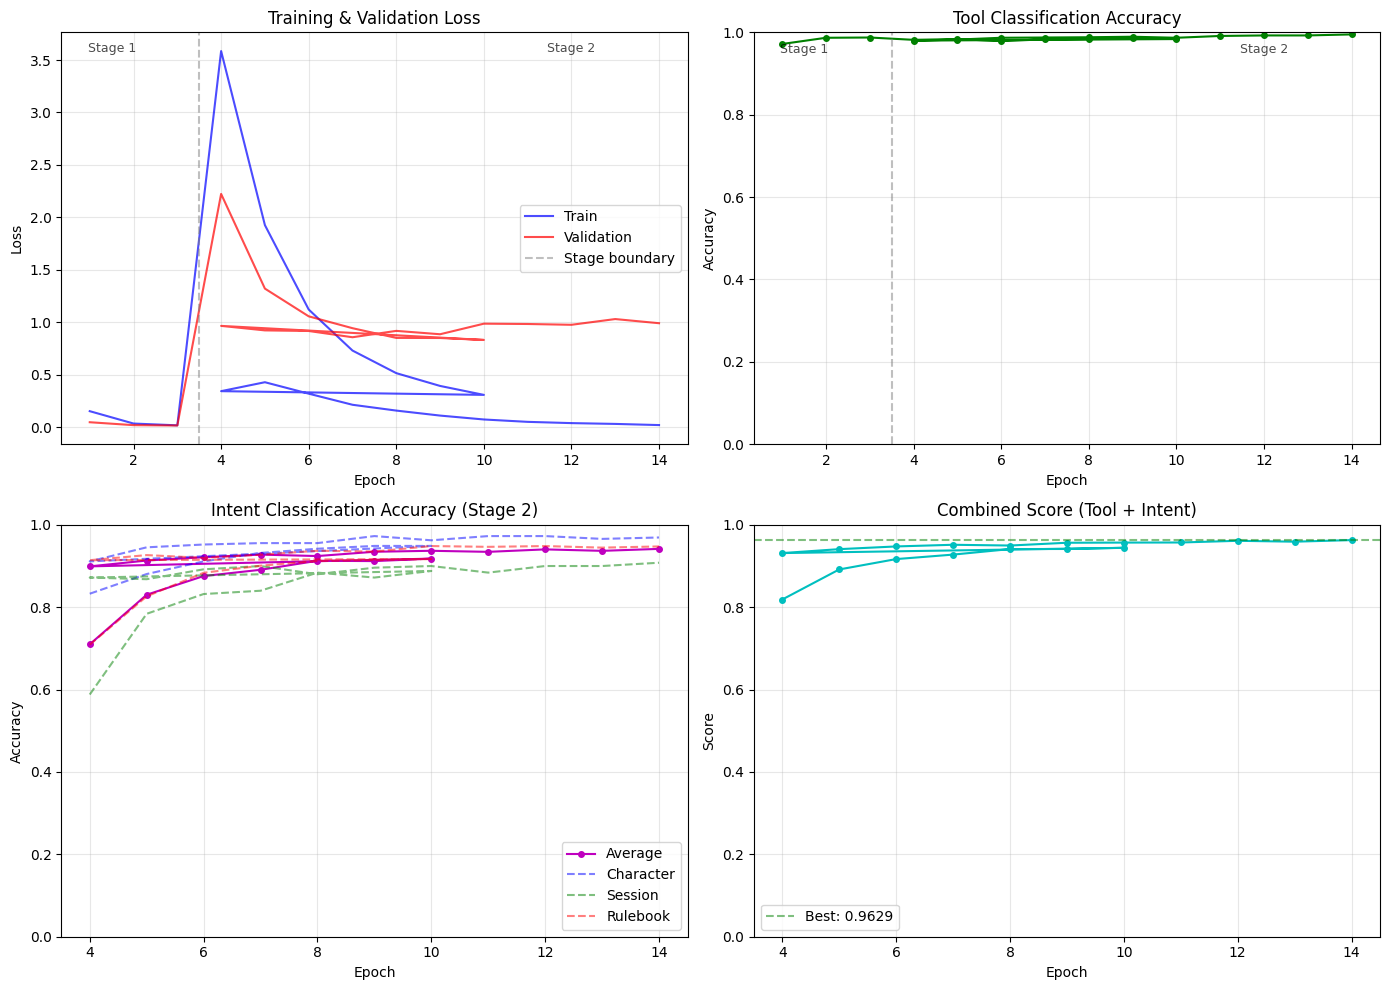

✓ Training history plot saved to /content/drive/MyDrive/574-assignment/results/training_history.png


In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = [h['epoch'] for h in training_history]
stage1_end = CONFIG['stage1_epochs']

# Loss curves
axes[0, 0].plot(epochs, [h['train_loss'] for h in training_history], 'b-', label='Train', alpha=0.7)
axes[0, 0].plot(epochs, [h['val_loss'] for h in training_history], 'r-', label='Validation', alpha=0.7)
axes[0, 0].axvline(x=stage1_end + 0.5, color='gray', linestyle='--', alpha=0.5, label='Stage boundary')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Tool accuracy
axes[0, 1].plot(epochs, [h['val_tool_acc'] for h in training_history], 'g-', marker='o', markersize=4)
axes[0, 1].axvline(x=stage1_end + 0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Tool Classification Accuracy')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# Intent accuracy (only Stage 2)
stage2_history = [h for h in training_history if h['stage'] == 'stage2']
if stage2_history:
    stage2_epochs = [h['epoch'] for h in stage2_history]
    axes[1, 0].plot(stage2_epochs, [h['val_avg_intent_acc'] for h in stage2_history], 'm-', marker='o', markersize=4, label='Average')
    axes[1, 0].plot(stage2_epochs, [h['val_character_intent_acc'] for h in stage2_history], 'b--', alpha=0.5, label='Character')
    axes[1, 0].plot(stage2_epochs, [h['val_session_intent_acc'] for h in stage2_history], 'g--', alpha=0.5, label='Session')
    axes[1, 0].plot(stage2_epochs, [h['val_rulebook_intent_acc'] for h in stage2_history], 'r--', alpha=0.5, label='Rulebook')
    axes[1, 0].legend(loc='lower right')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Intent Classification Accuracy (Stage 2)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Combined score (Stage 2)
if stage2_history:
    axes[1, 1].plot(stage2_epochs, [h['combined_score'] for h in stage2_history], 'c-', marker='o', markersize=4)
    axes[1, 1].axhline(y=best_combined_score, color='green', linestyle='--', alpha=0.5, label=f'Best: {best_combined_score:.4f}')
    axes[1, 1].legend()
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Combined Score (Tool + Intent)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

# Add stage labels
for ax in [axes[0, 0], axes[0, 1]]:
    ylim = ax.get_ylim()
    ax.text(stage1_end/2, ylim[1]*0.95, 'Stage 1', ha='center', fontsize=9, alpha=0.7)
    ax.text((stage1_end + len(epochs))/2, ylim[1]*0.95, 'Stage 2', ha='center', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'training_history.png', dpi=150)
plt.show()

print(f"✓ Training history plot saved to {RESULTS_PATH}/training_history.png")

## 15. Inference Examples

In [35]:
def predict(text, model, tokenizer, label_mappings, device):
    """
    Predict tool and intent for a single text query.
    """
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        max_length=CONFIG['max_length'],
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Index to label mappings
    idx_to_tool = {v: k for k, v in label_mappings['tool_to_idx'].items()}

    with torch.no_grad():
        tool_logits, intent_logits_dict = model(input_ids, attention_mask)

        # Align logits keys
        if 'character' in intent_logits_dict:
            intent_logits_dict['character_data'] = intent_logits_dict['character']

        # Apply temperature scaling for calibrated probabilities
        tool_probs = F.softmax(tool_logits / model.temperature, dim=-1)
        tool_pred = torch.argmax(tool_probs, dim=-1).item()
        tool_conf = tool_probs[0, tool_pred].item()
        tool_name = idx_to_tool[tool_pred]

        # Get intent for predicted tool
        intent_logits = intent_logits_dict[tool_name]
        intent_probs = F.softmax(intent_logits / model.temperature, dim=-1)
        intent_pred = torch.argmax(intent_probs, dim=-1).item()
        intent_conf = intent_probs[0, intent_pred].item()

        # FIXED: Use 'intent_to_idx_per_tool' instead of 'intent_to_idx'
        idx_to_intent = {v: k for k, v in label_mappings['intent_to_idx_per_tool'][tool_name].items()}
        intent_name = idx_to_intent[intent_pred]

    return {
        'text': text,
        'tool': tool_name,
        'tool_confidence': tool_conf,
        'intent': intent_name,
        'intent_confidence': intent_conf,
        'combined_confidence': tool_conf * intent_conf
    }

print("✓ predict() function defined")

✓ predict() function defined


In [36]:
# Test with example queries
test_queries = [
    "What's {CHARACTER}'s armor class?",
    "How does Fireball work?",
    "Did we meet {NPC} in the last session?",
    "What level is {CHARACTER}?",
    "Tell me about the Beholder's abilities",
    "What happened when {PARTY_MEMBER} fought the dragon?",
    "List all my spells",
    "Explain opportunity attacks",
    "Who did we talk to at the tavern?",
]

print("=" * 70)
print("EXAMPLE PREDICTIONS")
print("=" * 70)

for query in test_queries:
    result = predict(query, model, tokenizer, LABEL_MAPPINGS, device)
    print(f"\nQuery: {query}")
    print(f"  Tool: {result['tool']:15} (conf: {result['tool_confidence']:.3f})")
    print(f"  Intent: {result['intent']:20} (conf: {result['intent_confidence']:.3f})")
    print(f"  Combined confidence: {result['combined_confidence']:.3f}")

EXAMPLE PREDICTIONS

Query: What's {CHARACTER}'s armor class?
  Tool: character_data  (conf: 0.997)
  Intent: combat_info          (conf: 0.991)
  Combined confidence: 0.988

Query: How does Fireball work?
  Tool: rulebook        (conf: 1.000)
  Intent: describe_entity      (conf: 0.828)
  Combined confidence: 0.828

Query: Did we meet {NPC} in the last session?
  Tool: session_notes   (conf: 0.970)
  Intent: npc_info             (conf: 0.494)
  Combined confidence: 0.479

Query: What level is {CHARACTER}?
  Tool: character_data  (conf: 0.985)
  Intent: character_basics     (conf: 1.000)
  Combined confidence: 0.985

Query: Tell me about the Beholder's abilities
  Tool: rulebook        (conf: 0.996)
  Intent: describe_entity      (conf: 0.983)
  Combined confidence: 0.979

Query: What happened when {PARTY_MEMBER} fought the dragon?
  Tool: session_notes   (conf: 1.000)
  Intent: combat_recap         (conf: 1.000)
  Combined confidence: 1.000

Query: List all my spells
  Tool: character

## 16. Save Model & Artifacts

In [37]:
# Save all artifacts
print("\n" + "=" * 70)
print("SAVING MODEL & ARTIFACTS")
print("=" * 70)

model_dir = RESULTS_PATH / 'model'
model_dir.mkdir(exist_ok=True)

# 1. Save model weights
model_path = model_dir / 'joint_classifier.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'temperature': model.temperature.item(),
    'config': CONFIG,
    'tool_classes': list(LABEL_MAPPINGS['tool_to_idx'].keys()),
    'intent_classes': {k: list(v.keys()) for k, v in LABEL_MAPPINGS['intent_to_idx_per_tool'].items()},
}, model_path)
print(f"✓ Model saved to {model_path}")

# 2. Save tokenizer
tokenizer_path = model_dir / 'tokenizer'
tokenizer.save_pretrained(tokenizer_path)
print(f"✓ Tokenizer saved to {tokenizer_path}")

# 3. Save label mappings
mappings_path = model_dir / 'label_mappings.json'
with open(mappings_path, 'w') as f:
    json.dump(LABEL_MAPPINGS, f, indent=2)
print(f"✓ Label mappings saved to {mappings_path}")

# 4. Save training history
history_path = RESULTS_PATH / 'training_history.json'
with open(history_path, 'w') as f:
    json.dump(training_history, f, indent=2)
print(f"✓ Training history saved to {history_path}")

# 5. Save test results
test_results_path = RESULTS_PATH / 'test_results.json'
with open(test_results_path, 'w') as f:
    # Ensure variables exist (in case cells were skipped, though flow implies they ran)
    # Default to placeholders if not found to prevent crash during save
    t_metrics = test_metrics if 'test_metrics' in locals() else {}
    temp_val = model.temperature.item() if hasattr(model, 'temperature') else 1.0
    e_before = ece_before if 'ece_before' in locals() else 0.0
    e_after = ece_after if 'ece_after' in locals() else 0.0

    json.dump({
        'test_metrics': t_metrics,
        'calibrated_temperature': temp_val,
        'ece_before': e_before,
        'ece_after': e_after,
    }, f, indent=2)
print(f"✓ Test results saved to {test_results_path}")

# Summary
print("\n" + "=" * 70)
print("ARTIFACTS SAVED")
print("=" * 70)
print(f"Model directory: {model_dir}")
print(f"  - joint_classifier.pt (model weights + temperature)")
print(f"  - tokenizer/ (DeBERTa tokenizer)")
print(f"  - label_mappings.json (tool/intent indices)")
print(f"\nResults directory: {RESULTS_PATH}")
print(f"  - training_history.json")
print(f"  - training_history.png")
print(f"  - test_results.json")


SAVING MODEL & ARTIFACTS
✓ Model saved to /content/drive/MyDrive/574-assignment/results/model/joint_classifier.pt
✓ Tokenizer saved to /content/drive/MyDrive/574-assignment/results/model/tokenizer
✓ Label mappings saved to /content/drive/MyDrive/574-assignment/results/model/label_mappings.json
✓ Training history saved to /content/drive/MyDrive/574-assignment/results/training_history.json
✓ Test results saved to /content/drive/MyDrive/574-assignment/results/test_results.json

ARTIFACTS SAVED
Model directory: /content/drive/MyDrive/574-assignment/results/model
  - joint_classifier.pt (model weights + temperature)
  - tokenizer/ (DeBERTa tokenizer)
  - label_mappings.json (tool/intent indices)

Results directory: /content/drive/MyDrive/574-assignment/results
  - training_history.json
  - training_history.png
  - test_results.json


## Summary

### Architecture
- **Encoder**: DeBERTa-v3-base (86M params)
- **Tool Head**: Linear classifier (3 classes)
- **Intent Heads**: Per-tool classifiers (10 + 20 + 30 classes)
- **No NER**: Entity extraction via gazetteer at inference

### Training
- **Loss**: Focal Loss (γ=2.0) with Label Smoothing (0.1)
- **Optimizer**: AdamW with differential LRs (1e-5 encoder, 1e-4 heads)
- **Schedule**: Linear warmup + decay
- **Stages**: Gradual unfreezing (tool first, then joint)

### Calibration
- **Method**: Temperature Scaling (post-training)
- **Metric**: Expected Calibration Error (ECE)

### Inference Flow
```
Input: "What level is Duskryn?"
  ↓
Normalize: "What level is {CHARACTER}?"  (external)
  ↓
Tokenize → DeBERTa → [CLS] embedding
  ↓
Tool Head → "character_data" (softmax/T)
  ↓
Intent Head[character] → "character_basics" (softmax/T)
  ↓
Output: {tool: "character_data", intent: "character_basics", confidence: 0.95}
```